In [4]:
from desc.examples import get
from desc.magnetic_fields import FourierCurrentPotentialField
from desc.grid import LinearGrid
from desc.derivatives import Derivative
from desc.backend import jnp

In [15]:
eq = get("ESTELL")
grid = LinearGrid(M=30,N=30,NFP=eq.NFP) # idk if sym=True is needed or not tbh so we will leave no sym here
data = eq.compute(["K_vc"],grid=grid)

field = FourierCurrentPotentialField.from_surface(surface=eq.surface,M_Phi=20,N_Phi=20,sym_Phi=False)
def surf_curr(x):
    # x is [I,G,phi_mn]
    params = field.params_dict
    params["I"]=x[0]
    params["G"]=x[1]
    params["Phi_mn"]=x[2:]
    return field.compute("K",grid=grid,params=params)["K"].flatten(order="F")
# jacobian of the above fxn is the A s.t. Ax = K_field where K_field is the K of the FourierCurrentPotentialField
# since K is linear in x
A = Derivative(surf_curr)(jnp.zeros(field.Phi_mn.size+2))
# pseudoinvert Ax = K_vc to fit the field params to the virtual casing current
K_vc = data["K_vc"].flatten(order="F")
x = jnp.linalg.pinv(A) @ K_vc
field.I = x[0]
field.G = x[1]
field.Phi_mn = x[2:]

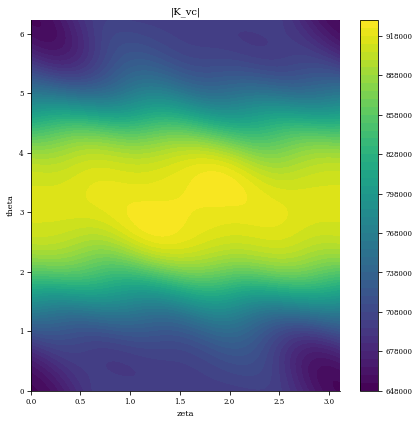

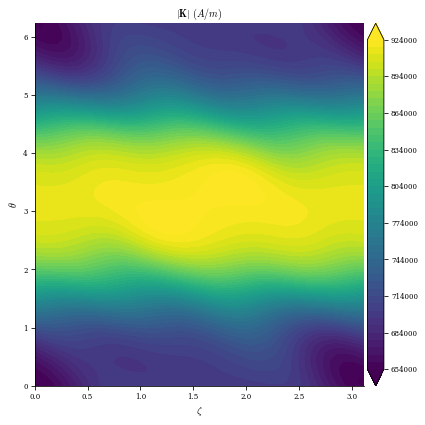

In [21]:
import matplotlib.pyplot as plt
plot_grid = LinearGrid(N=60,M=60,NFP=eq.NFP)
plt.figure(figsize=(6,6))
theta = plot_grid.nodes[:,1].reshape(plot_grid.num_zeta, plot_grid.num_theta)
zeta = plot_grid.nodes[:,2].reshape(plot_grid.num_zeta, plot_grid.num_theta)
data_eq = eq.compute("K_vc",grid=plot_grid)
Kmag = jnp.linalg.norm(data_eq["K_vc"],axis=1)
plt.contourf(zeta, theta, Kmag.reshape(plot_grid.num_zeta, plot_grid.num_theta),levels=50)
plt.title("|K_vc|")
plt.xlabel("zeta")
plt.ylabel("theta")
plt.colorbar()
from desc.plotting import plot_2d
_,_,data_field=plot_2d(field,"K",grid=plot_grid,cmap="viridis",levels=50,figsize=(6,6),return_data=True)

In [26]:
error_mag = abs(jnp.linalg.norm(data_eq["K_vc"],axis=1) - data_field["K"].flatten(order="F") )

print(f"Max error: {jnp.max(error_mag)}")
print(f"Min error: {jnp.min(error_mag)}")
print(f"Avg error: {jnp.mean(error_mag)}\n")

rel_error_mag = error_mag / jnp.linalg.norm(data["K_vc"])

print(f"Max rel error: {jnp.max(rel_error_mag)}")
print(f"Min rel error: {jnp.min(rel_error_mag)}")
print(f"Avg rel error: {jnp.mean(rel_error_mag)}")


Max error: 351.00868825649377
Min error: 0.010242954944260418
Avg error: 56.246205888225695

Max rel error: 7.137577041846773e-06
Min rel error: 2.0828510090154867e-10
Avg rel error: 1.1437370107073392e-06


In [29]:
from desc.plotting import poincare_plot, plot_surfaces

(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

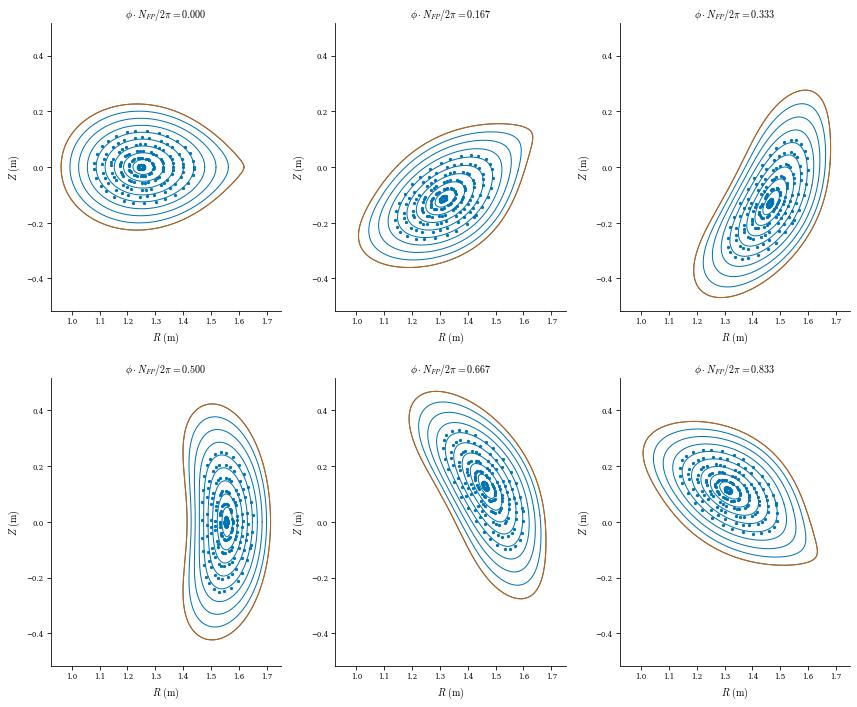

In [37]:
# takes a minute or two to run
grid = LinearGrid(rho=np.linspace(0.01, 1.0,10))
pos_data = eq.compute(["R","Z"],grid=grid)
fig,ax = plot_surfaces(eq,theta=0,rho=grid.nodes[:,0])
poincare_plot(field,R0=pos_data["R"][:-4],Z0=pos_data["Z"][:-4],ntransit=30,ax=ax)